# Практические задачи

## 1 задача 

Давайте познакомимся с нашими данными чуть ближе, чем названия колонок и их содержание! Первое, что мы можем сделать - это посчитать описательные статистики по лайкам и просмотрам.




In [79]:
#Формируем в SQL удобный датасет для нас
import pandahouse
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import pandas as pd

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = '''SELECT post_id,
              countIf(action = 'like') as like,
              countIf(action = 'view') as view
       from simulator_20220520.feed_actions
       group by post_id'''

df = pandahouse.read_clickhouse(q, connection=connection)

df.head()


,post_id,like,view
0,610,2271,10727
1,4660,192,1637
2,4742,1,11
3,720,1089,6120
4,948,2051,9846


In [80]:
round(df.describe(), 2)

,post_id,like,view
count,6091.00,6091.00,6091.00
mean,3181.78,1528.02,7299.81
std,1829.92,2925.87,11267.52
min,1.00,0.00,1.00
25%,1604.50,48.00,536.00
50%,3185.00,325.00,2634.00
75%,4765.50,1539.50,9055.50
max,6382.00,31714.00,104338.00


#### Задача звучит так "Укажите, что из этого НЕ ХАРАКТЕРНО для наших данных":
 1. По мерам центральной тенденции просмотры опережают лайки. 
    * (Верно, тут всё логично, просмотров всегда больше, чем лайков) 
 2. Медиана лайков приблизительно такая же, как и среднее по ним же. 
    * (Неверно, на таблице выше видно, что медиана и среднее значение по лайкам отличается)
 3. Самые популярные посты собирают миллионы просмотров. 
    * (Неверно, как видно даже близко не приближаемся к миллиону просмотров на посте)


## 2 задача

Нарисуйте распределения просмотров и лайков. Какая у них форма и есть ли различия в этой форме?

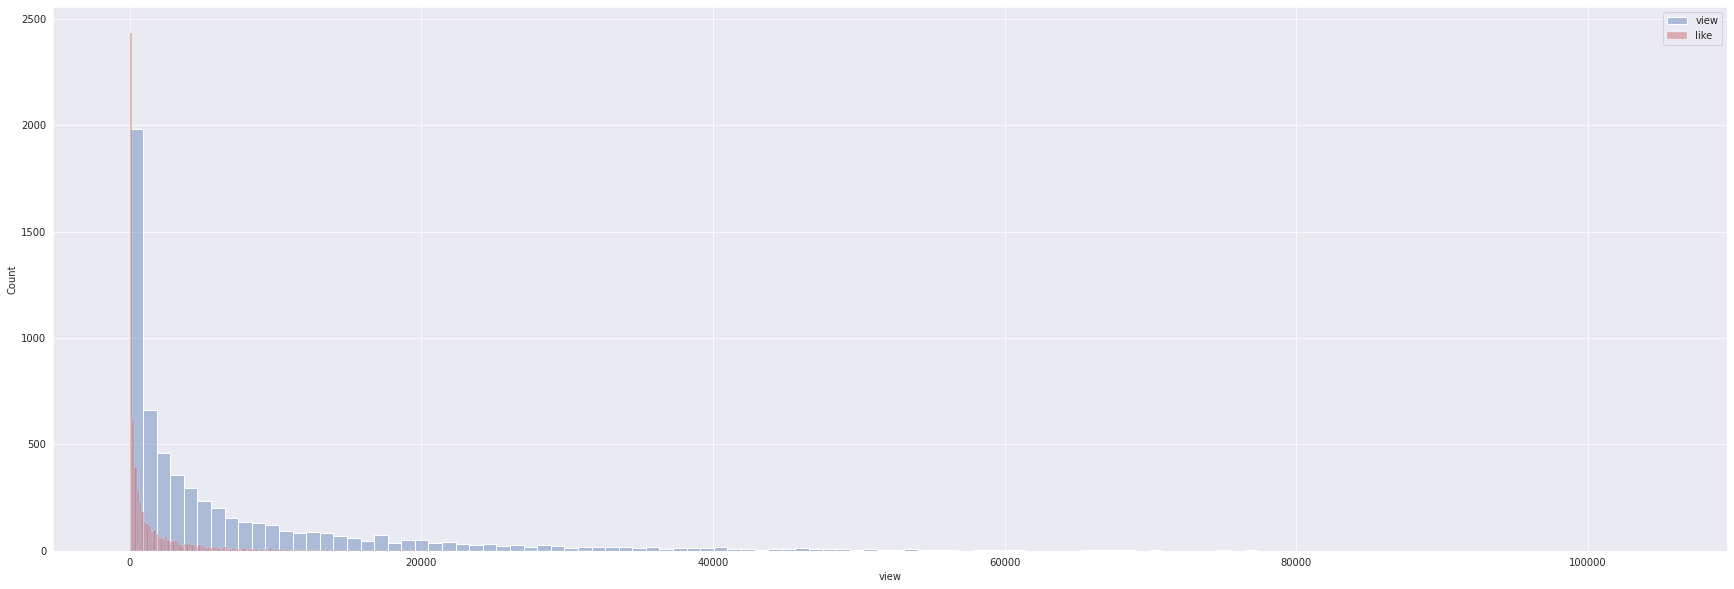

In [91]:
#Строим гистограммы для лайков и просмотров.
sns.set({'figure.figsize':(30,10)})
sns.histplot(x = 'view', data = df, color = 'b', alpha = 0.4, label = 'view')
sns.histplot(x = 'like', data = df, color = 'r', alpha = 0.4, label = 'like')
plt.legend(labels = ['view', 'like'])

In [50]:
#Приводим наши данные к Z-значениям, так как они лежат в разных разных шкалах.
df['z_like'] = stats.zscore(df['like'])
df['z_view'] = stats.zscore(df['view'])
df.head(2)

,post_id,like,view,z_like,z_view
0,610,2271,10727,0.253993,0.304232
1,4660,192,1637,-0.456650,-0.502602


/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


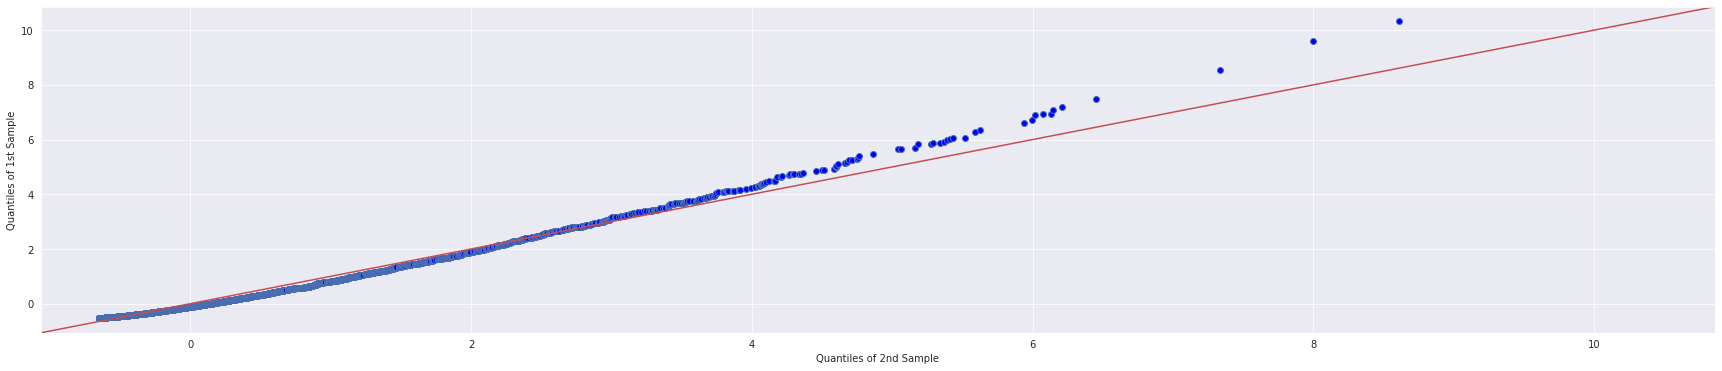

In [51]:
#Строим QQ-график 
qqplot_2samples(df['z_like'], df['z_view'], line = '45')
plt.show()

#### Выберите правильные варианты:
 1. Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений
    * (Верно, так как на втором графике видно, что распределение точек распростроняется от линии к правой части графика дальше и дальше)
2. Есть пик около нуля/единицы как для просмотров, так и для лайков
    * (Верно, как видим на первом графике распределения лайков/показов пик приходится как раз на 0/1)
3. Для данных характерна левосторонняя асимметрия
    * (Неверно, по первому графику видно, что ассиметрия правосторонняя)
4. Для данных характерна положительная асимметрия
    * (Верно, по первому  графику видим провосторонюю ассиметрию, она же положительная)
5. В данных хорошо видны подгруппы
    * (Неверно, подгрупп на первом графике не вижу)

## 3 задача

#### Посчитайте CTR и время существования для каждого из постов (от первого просмотра поста). Затем:

1. Нарисуйте их распределения
2. Постройте корреляционную матрицу между ними, просмотрами и лайками
3. Визуализируйте все эти взаимосвязи в виде диаграмм рассеяния

In [52]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = '''select post_id,
               countIf(action = 'like') as like,
               countIf(action = 'view') as view,
               max(time) as time_max,
               min(time) as time_min,
               datediff(hour, time_min, time_max) as lifepost_hour,
               like / view as ctr
        from simulator_20220520.feed_actions
        group by post_id'''

lifepost_df = pandahouse.read_clickhouse(q, connection=connection)

lifepost_df.head()

,post_id,like,view,time_max,time_min,lifepost_hour,ctr
0,610,2271,10727,2022-04-09 01:54:32,2022-04-05 15:18:51,82,0.211709
1,4660,192,1637,2022-06-01 15:58:05,2022-05-31 20:04:17,19,0.117288
2,4742,1,11,2022-06-01 23:58:09,2022-06-01 23:37:38,0,0.090909
3,720,1089,6120,2022-04-09 03:59:49,2022-04-06 14:10:16,61,0.177941
4,948,2051,9846,2022-04-12 19:55:55,2022-04-09 19:49:26,72,0.208308


<AxesSubplot:xlabel='ctr', ylabel='Count'>

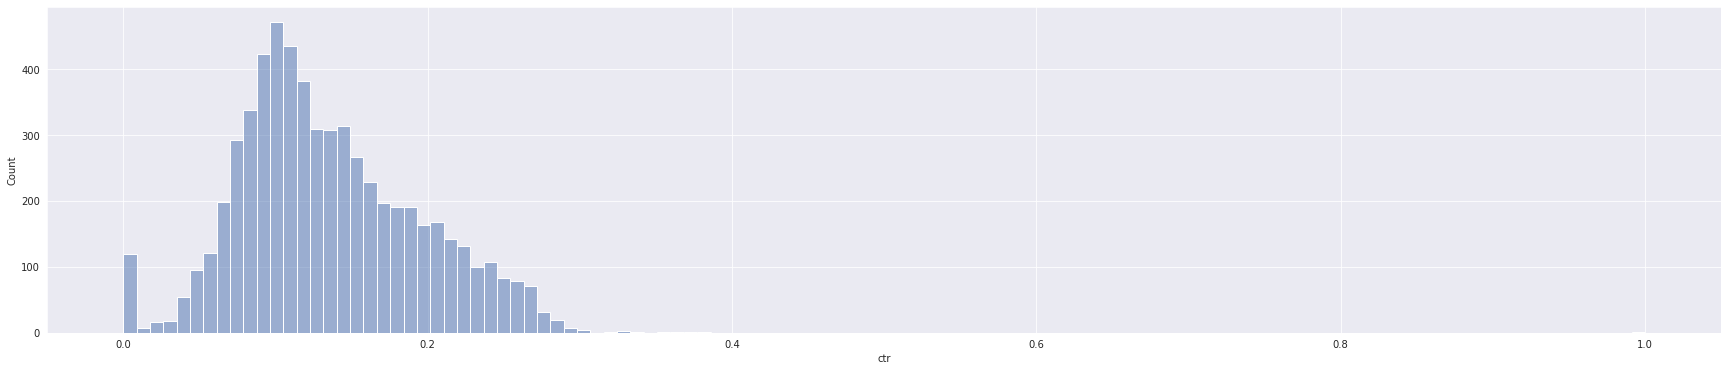

In [53]:
sns.histplot(x = 'ctr', data = lifepost_df, alpha = 0.5)

In [54]:
#Находим среднее значение "жизни" поста
lifepost_df.lifepost_hour.mean()

38.712034148744046

In [55]:
numeric_col = ['like','view', 'lifepost_hour', 'ctr']
corr_matrix = lifepost_df.loc[:,numeric_col].corr()
corr_matrix

,like,view,lifepost_hour,ctr
like,1.000000,0.990049,0.829569,0.746511
view,0.990049,1.000000,0.875404,0.793137
lifepost_hour,0.829569,0.875404,1.000000,0.901553
ctr,0.746511,0.793137,0.901553,1.000000


<AxesSubplot:>

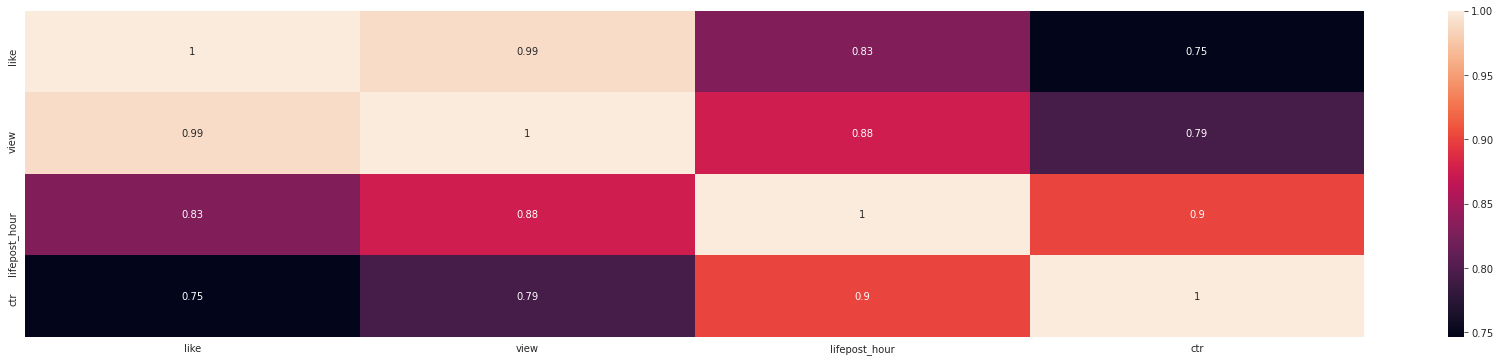

In [56]:
sns.heatmap(corr_matrix, annot=True)

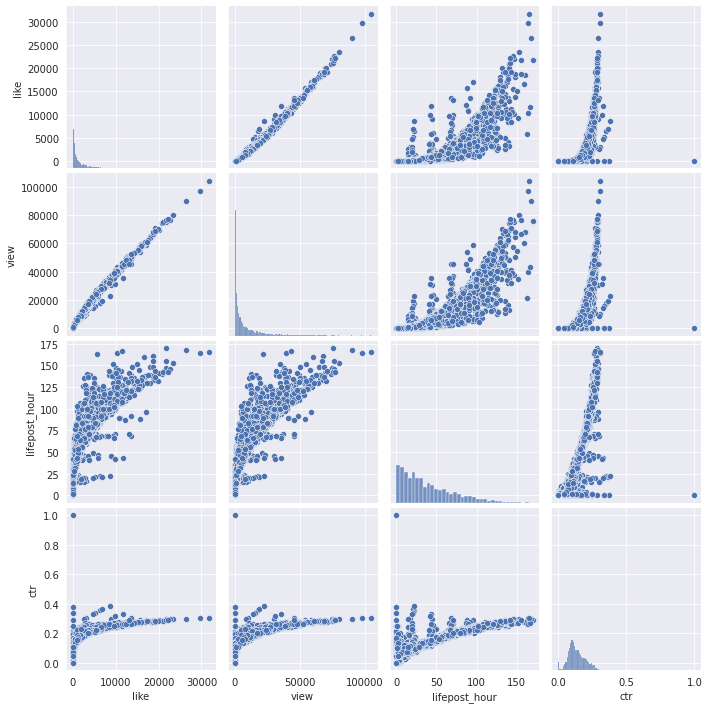

In [57]:
filter = lifepost_df.loc[:,numeric_col]
sns.pairplot(filter)

####  Какие суждения об этих величинах верны?
1. Между количеством лайков и временем существования поста связь линейная
    * (Неверно, лиейной связи тут не наблюдаем)
2. Сильнее всего коррелируют CTR и время существования поста
    * (По результатам корреляционной модели видим, что это утверждение верно)
3. По сравнению с просмотрами и лайками CTR менее асимметричен
    * (Верно, по первого графику видим, что CTR менее асимметричен)
4. В среднем посты "живут" пять дней
    * (Неверно, посты живут в среднем 39 часов)

## 4 Задача

Всё это время мы оценивали наши данные "в статике". Давайте теперь обратимся к их динамике! Попробуем определить, что вообще приводит к изменениям в наших метриках - в самом первом приближении.

Нарисуйте дневную динамику активности уникальных пользователей, а затем просмотра уникальных постов.

In [58]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = '''select toStartOfDay(toDateTime(time)) AS time,
               count(DISTINCT user_id) as uniq_users,
               count(DISTINCT post_id) as uniq_post,
               countIf(action = 'like') as like,
               countIf(action = 'view') as view
        from simulator_20220520.feed_actions
        GROUP BY time'''

dinamik_df = pandahouse.read_clickhouse(q, connection=connection)

dinamik_df.head()

,time,uniq_users,uniq_post,like,view
0,2022-06-20,18984,240,164457,767819
1,2022-03-29,2325,150,13305,60906
2,2022-06-17,18885,195,128146,604637
3,2022-04-18,11373,218,81114,399625
4,2022-04-06,7743,200,58427,272735


<AxesSubplot:xlabel='time', ylabel='uniq_users'>

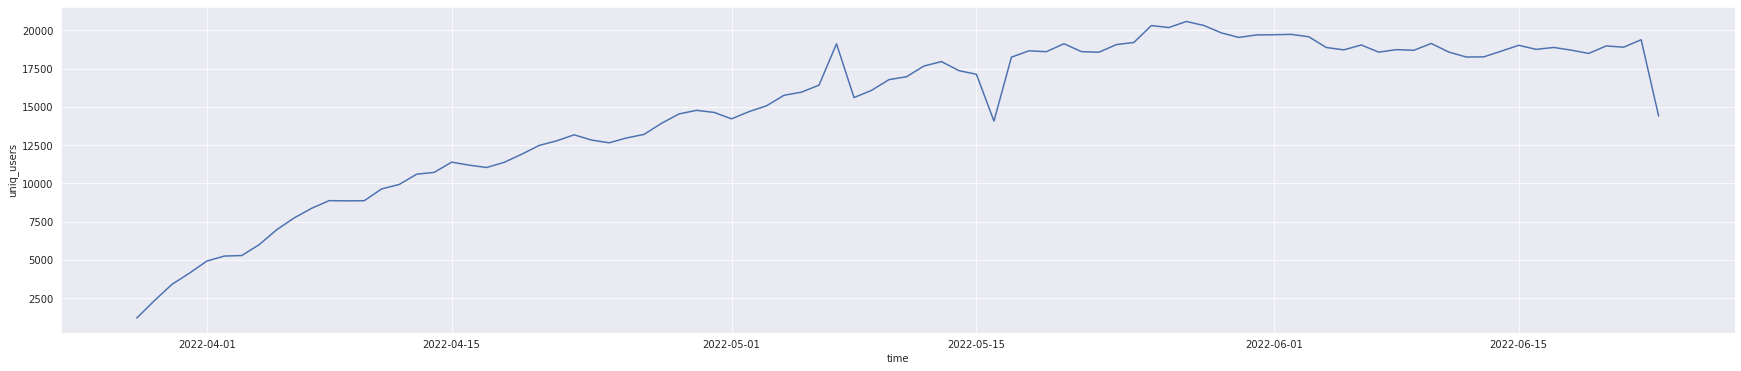

In [59]:
#График активности уникальных пользователей
sns.lineplot(data = dinamik_df, x = 'time', y = 'uniq_users')

<AxesSubplot:xlabel='time', ylabel='uniq_post'>

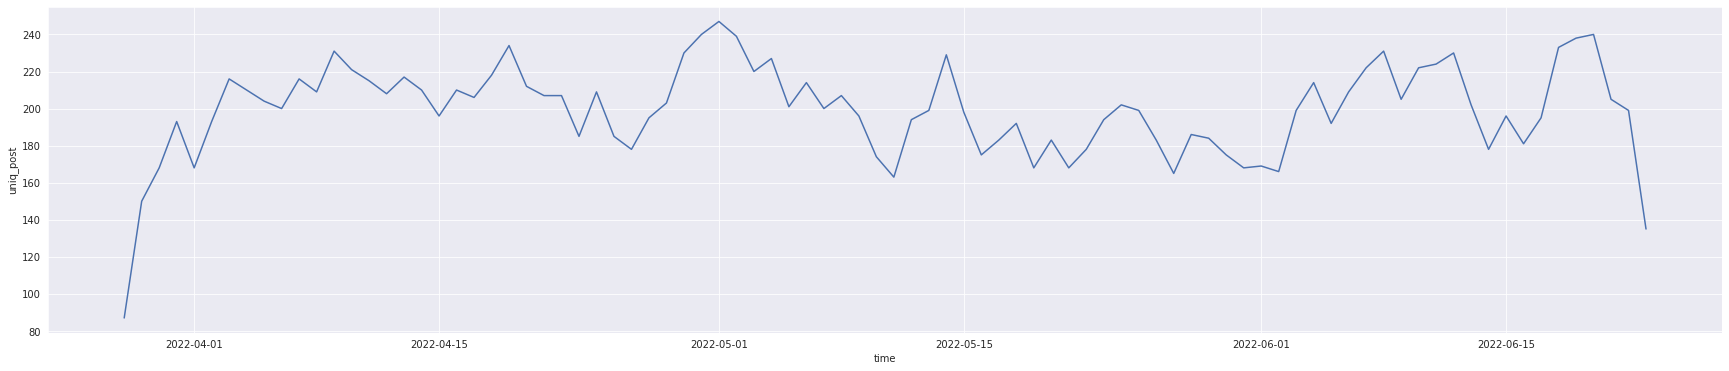

In [60]:
#График просмотров уникальных постов
sns.lineplot(data = dinamik_df, x = 'time', y = 'uniq_post')

#### Соотносим утверждения:
| Метрика | Утверждение |
|---------|-------------|
|Уникальные пользователи|Постоянный рост с небольшими флуктуациями|
|Просмотры уникальных постов|Резкий рост в начале, затем случайные колебания вокруг одного уровня|



## 5 Задача

Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса.

Возьмите почасовую динамику активности за весь период и проанализируйте её.

In [93]:
from statsmodels.tsa.seasonal import STL

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = '''select toStartOfHour(toDateTime(time)) AS time, count(action) as action
        from simulator_20220520.feed_actions
        GROUP BY time'''

hourtime_df = pandahouse.read_clickhouse(q, connection=connection)

hourtime_df.head()

,time,action
0,2022-05-11 18:00:00,36572
1,2022-05-13 21:00:00,40422
2,2022-05-29 21:00:00,50097
3,2022-04-07 19:00:00,22469
4,2022-05-06 08:00:00,24377


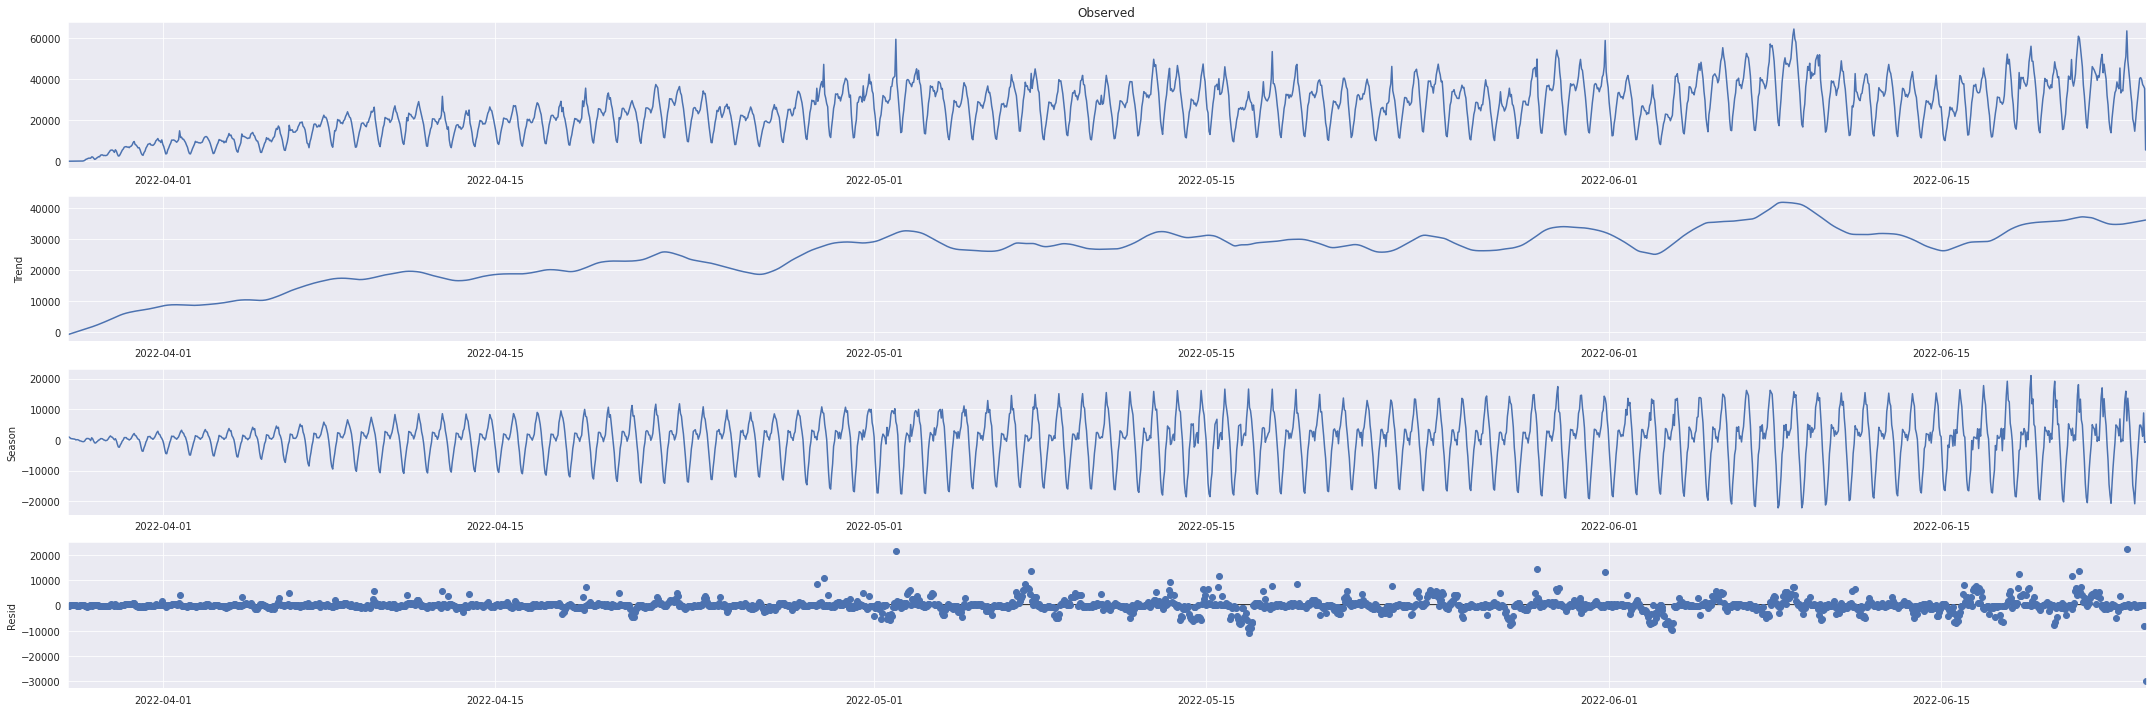

In [99]:
global_time = hourtime_df.set_index("time").resample(rule="H").ffill()
wq = STL(global_time, robust = True).fit()
wq.plot()
plt.show()

#### Соотносим утверждения:
| Метрика | Утверждение |
|---------|-------------|
|Первый график|Оригинальный временной ряд|
|Второй график|Общий тренд активности|
|Третий график|Повторяющиеся дневные регулярности в данных|
|Четвёртый график|Остатки модели|



## 6 Задача

Вы могли заметить из прошлого задания, что просмотры постов "колеблются" в течение дня. Вопрос: а отличается ли распределение дневной активности пользователей от распределения публикации постов? В качестве прокси времени публикации возьмите время первого просмотра поста.

Визуализируйте оба распределения для каждого часа дня.

In [195]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = '''select count(user_id) as uniq_users, toStartOfHour(toDateTime(time)) as time,
               countIf(action = 'like') as like,
               countIf(action = 'view') as view
        from simulator_20220520.feed_actions
        group by time'''

df1 = pandahouse.read_clickhouse(q, connection=connection)

df1.head(2)

,uniq_users,time,like,view
0,36572,2022-05-11 18:00:00,6537,30035
1,40422,2022-05-13 21:00:00,6743,33679


<AxesSubplot:xlabel='hour', ylabel='uniq_users'>

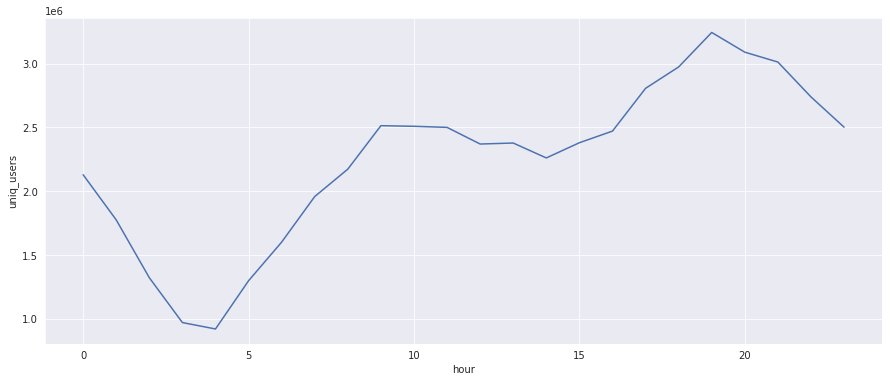

In [200]:
#В отдельный столбец выносим данные по часу и группируем по этому столбцу. Стороим график по активности пользователей.
df1['hour'] = df1.time.dt.hour
gr = df1.groupby('hour')['uniq_users'].sum().reset_index()
sns.set({'figure.figsize':(15,6)})
sns.lineplot(data = gr, x = 'hour', y = 'uniq_users', size_order = 10)

<AxesSubplot:xlabel='hour', ylabel='post_id'>

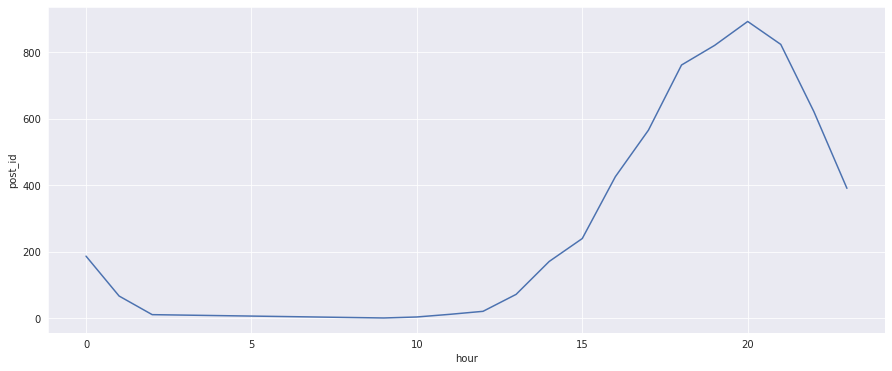

In [201]:
#Данные берём из датасета 3-го задания, так как там уже считали минимальное время для каждого поста. Строим график по активности постинга.
#В отдельный столбец выносим данные по часу и группируем по этому столбцу
lifepost_df['hour'] = lifepost_df.time_min.dt.hour
gr = lifepost_df.groupby('hour')['post_id'].count().reset_index()
sns.lineplot(data = gr, x = 'hour', y = 'post_id')

##### Выберем правильные утверждения:

1. Наименьшая активность пользователей наблюдается в 5 утра
    * (Неверно, наименьшую активность наблюдаем в 4 утра)
2. Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением
    * (Неверно, линейного роста тут не наблюдаем)
3. Посты публикуются круглосуточно
    * (Неверно, с 2 до 12 видим нулевую активность в постах)
4. Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине
    * (Верно, всё так и есть)
5. Больше всего постов публикуется в районе 8 вечера
    * (Верно, пик видим именно в 8 вечера)
6. Пики активности пользователей и публикации постов не совпадают
    * (Верно, у постов пик активности в 8 часов, а у пользователей в 7)